# Cours #2a - Classification d'images à l'aide de réseaux neuronaux convolutifs profonds (CNN)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geo-stack/cours_ml_envirocan/blob/main/02a_training_cnn_example.ipynb)

## 1. Configuration de l'environnement

In [1]:
print("Installation de 'gdown' pour le téléchargement du dataset...", end='')
!pip install --upgrade gdown -q
print(' OK')

from pathlib import Path
import gdown
from zipfile import ZipFile

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm


#import torch
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.cm as cm


print('Environnement configuré avec succès!')

Installation de 'gdown' pour le téléchargement du dataset... OK
Environnement configuré avec succès!


## 2. Téléchargement et préparation du jeu de données

Le PlantVillage Dataset est un jeu de données d'images de feuilles de plantes conçu pour des tâches de classification d'images en agriculture (ex. diagnostic automatique de maladies). Il contient des photos de feuilles appartenant à plusieurs espèces/cultures (p. ex. tomate, pomme de terre, poivron, etc.) et à différentes classes correspondant à l'état sanitaire de la plante (feuille saine vs différentes maladies).

Dans un contexte d'apprentissage par CNN, ce dataset est souvent utilisé pour entraîner un modèle à reconnaître, à partir d'une image, la culture et/ou le type de maladie. Les images sont organisées par dossiers de classes, ce qui le rend pratique pour des pipelines classiques de vision par ordinateur (chargement par répertoires, augmentation de données, séparation entraînement/validation/test).

Référence (repo GitHub) : https://github.com/spMohanty/PlantVillage-Dataset.




In [2]:
import shutil
from pathlib import Path

zip_path = 'PlantVillage_color.zip'

print("Téléchargement du jeu de données en cours...", end='')

gdown.download(
    'https://drive.google.com/uc?id=18YiQv37m2VyUHeCPF1wSOR9l5Jm0hp0z',
    str(zip_path),
    quiet=True
    )

print("OK")

print("Extraction des données...", end='')

out_dir = Path("./plant_data")
if out_dir.exists():
    shutil.rmtree(out_dir)

with ZipFile(zip_path, "r") as zf:
    zf.extractall(out_dir)

print("OK")
print()

!ls plant_data

Téléchargement du jeu de données en cours...OK
Extraction des données...OK

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spott

## 3. Séparation du dataset et création des DataLoaders

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('./plant_data', transform=transform)

# 1. Définir les tailles de séparation (train / test)
train_ratio = 0.8
test_ratio = 1.0 - train_ratio

total_count = len(dataset)
train_count = int(total_count * train_ratio)
test_count = total_count - train_count

# 2. Effectuer la séparation
g = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(
    dataset, [train_count, test_count], generator=g
    )

# 3. Créer les DataLoaders
# Un batch size de 32 est généralement un choix prudent avec la
# mémoire GPU standard de Colab
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Nombre total d'images : {total_count}")
print(f"Ensemble d'entraînement : {len(train_dataset)}")
print(f"Ensemble de test : {len(test_dataset)}")


Nombre total d'images : 54305
Ensemble d'entraînement : 43444
Ensemble de test : 10861


## 4. Exploration du dataset

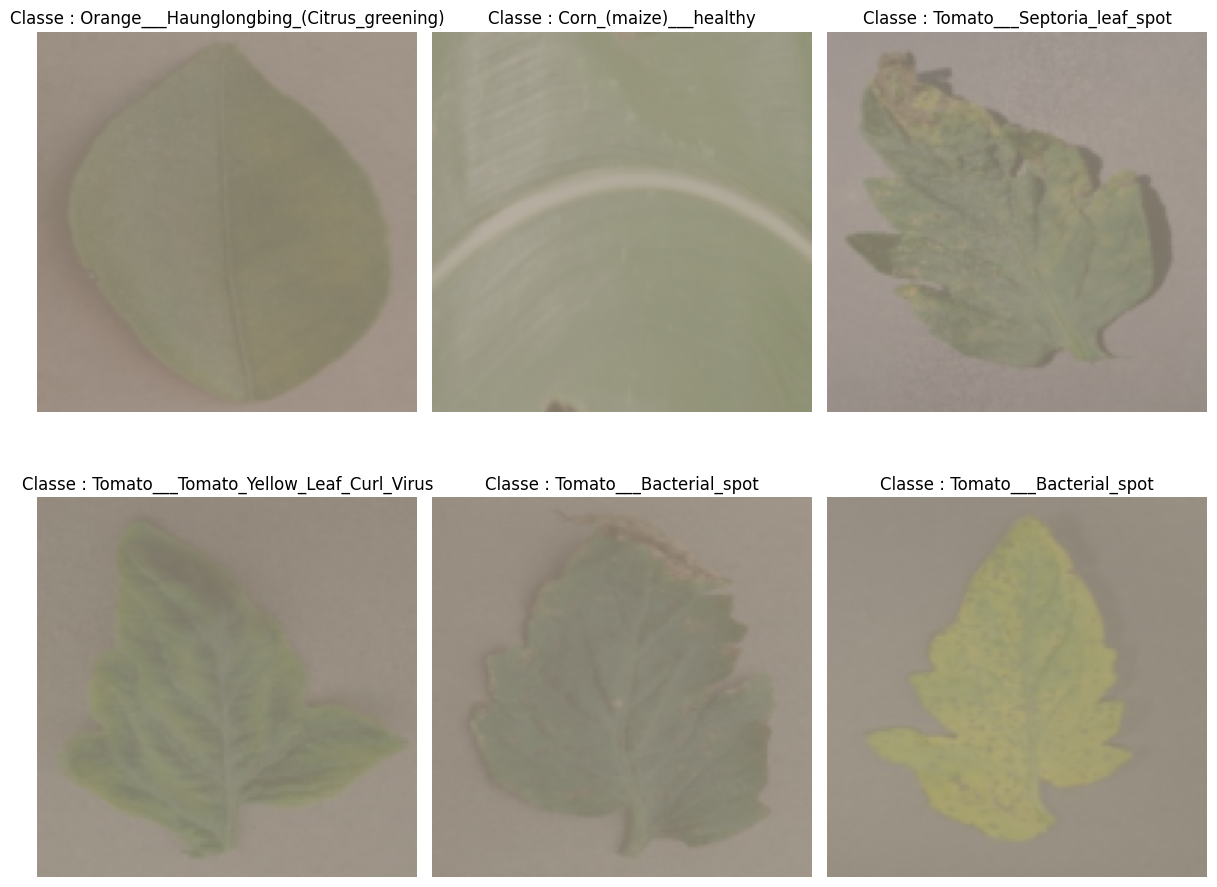

In [4]:
def show_dataset_examples(loader, classes, num_images=6):
    images, labels = next(iter(loader))

    plt.figure(figsize=(12, 10))

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)

        # PyTorch utilise le format (C, H, W), on doit le remettre
        # en (H, W, C) pour Matplotlib
        img = images[i].permute(1, 2, 0).numpy()

        # Annuler la normalisation ImageNet (moyenne et écart-type) pour
        # l'affichage
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean

        # S'assurer que les valeurs restent entre 0 et 1
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"Classe : {classes[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation
show_dataset_examples(train_loader, dataset.classes)

## 5. Construction de l'architecture du CNN

On utilise un réseau convolutionnel simple composé de deux blocs *convolution + ReLU + max-pooling*.

La première convolution transforme l'image RGB (3 canaux) en 32 cartes de caractéristiques, puis une opération de *max-pooling* réduit la résolution spatiale.

Un second bloc applique une convolution pour obtenir 64 cartes de caractéristiques, suivie d'un nouveau *max-pooling*, ce qui réduit encore la taille de l'image.

Les cartes de caractéristiques sont ensuite aplaties (*flatten*) et passées dans deux couches entièrement connectées : une couche cachée de 128 neurones et une couche de sortie de taille `num_classes` pour produire les scores de classification. Un *dropout (0.5)* est ajouté avant la couche finale afin de limiter le surapprentissage.

In [5]:
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Le calcul magique : 64 filtres * 32 (H) * 32 (W) = 65536
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Sortie: 32 filtres, 64x64
        x = self.pool(F.relu(self.conv2(x)))  # Sortie: 64 filtres, 32x32

        x = torch.flatten(x, 1)  # Transforme [32, 64, 32, 32] en [32, 65536]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# ──────────────────────────────────────────────
# 1.  EXTRACTION DES FEATURES (couche avant logits)
# ──────────────────────────────────────────────

def extract_features(model, data_loader, device, max_samples=2000):
    """
    Extrait les embeddings de la couche pénultième du modèle
    via un forward-hook, ainsi que les vraies étiquettes.

    Args:
        model       : modèle PyTorch entraîné
        data_loader : DataLoader (train ou test)
        device      : 'cuda' ou 'cpu'
        max_samples : nombre max d'exemples pour le t-SNE (pour la rapidité)

    Returns:
        features (np.ndarray) : (N, D) embeddings
        labels   (np.ndarray) : (N,)  étiquettes entières
    """
    model.eval()
    all_features = []
    all_labels   = []

    # ── Hook sur la dernière couche AVANT la classification ──
    # Fonctionne pour ResNet (model.fc), VGG (model.classifier[-1]),
    # ou n'importe quel modèle custom — adaptez si besoin.
    hook_output = {}

    def hook_fn(module, input, output):
        # On capture l'INPUT de la dernière couche linéaire
        hook_output['features'] = input[0].detach().cpu()

    # Détection automatique de la dernière couche linéaire
    last_linear = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            last_linear = module          # on garde le dernier

    if last_linear is None:
        raise ValueError("Aucune couche Linear trouvée dans le modèle.")

    hook_handle = last_linear.register_forward_hook(hook_fn)

    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extraction des features"):
            if total >= max_samples:
                break
            images = images.to(device)
            model(images)                             # forward → hook déclenché
            feats = hook_output['features']           # (batch, D)
            all_features.append(feats)
            all_labels.append(labels)
            total += images.size(0)

    hook_handle.remove()                              # nettoyage du hook

    features = torch.cat(all_features, dim=0)[:max_samples].numpy()
    labels   = torch.cat(all_labels,   dim=0)[:max_samples].numpy()
    return features, labels


# ──────────────────────────────────────────────
# 2.  CALCUL ET PLOT DU t-SNE
# ──────────────────────────────────────────────

def plot_tsne(features, labels,
              class_names=None,
              title="t-SNE des embeddings",
              perplexity=30,
              n_iter=1000,
              random_state=42,
              figsize=(12, 9),
              save_path=None):
    """
    Réduit les features en 2D via t-SNE et génère un scatter plot coloré.

    Args:
        features     : np.ndarray (N, D)
        labels       : np.ndarray (N,) entiers
        class_names  : liste des noms de classes (optionnel)
        title        : titre du graphique
        perplexity   : hyperparamètre t-SNE (5–50)
        n_iter       : nombre d'itérations t-SNE
        random_state : graine aléatoire pour la reproductibilité
        figsize      : taille de la figure
        save_path    : chemin pour sauvegarder (None = affichage seulement)
    """
    print(f"[t-SNE] Réduction de {features.shape} → 2D  "
          f"(perplexity={perplexity}, n_iter={n_iter}) …")

    tsne = TSNE(n_components=2,
                perplexity=perplexity,
                n_iter=n_iter,
                random_state=random_state,
                verbose=1)
    embeddings_2d = tsne.fit_transform(features)

    # ── Palette de couleurs ──
    unique_labels = np.unique(labels)
    n_classes     = len(unique_labels)
    palette       = sns.color_palette("hls", n_classes)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("#f8f9fa")
    fig.patch.set_facecolor("#ffffff")

    for idx, cls in enumerate(unique_labels):
        mask = labels == cls
        label_name = class_names[cls] if class_names else f"Classe {cls}"
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[palette[idx]],
            label=label_name,
            s=18,
            alpha=0.75,
            edgecolors='none'
        )

    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel("t-SNE Dim 1", fontsize=12)
    ax.set_ylabel("t-SNE Dim 2", fontsize=12)
    ax.legend(
        loc='upper right',
        bbox_to_anchor=(1.18, 1),
        frameon=True,
        fontsize=9,
        title="Classes",
        title_fontsize=10
    )
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"[t-SNE] Figure sauvegardée → {save_path}")

    plt.show()
    return embeddings_2d


## 6. Entraînement du modèle

Using device: cuda


Epoch 1/5: 100%|██████████| 1358/1358 [01:13<00:00, 18.45it/s]


Epoch   1 │ Train 75.78%  │  Test  74.27%

[t-SNE] Génération à l'époque 1 …


Extraction des features:  19%|█▊        | 63/340 [00:04<00:17, 15.44it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Réduction de (2000, 128) → 2D  (perplexity=30, n_iter=1000) …
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 7.528759
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.772758
[t-SNE] KL divergence after 1000 iterations: 1.016016
[t-SNE] Figure sauvegardée → tsne_epoch_001.png


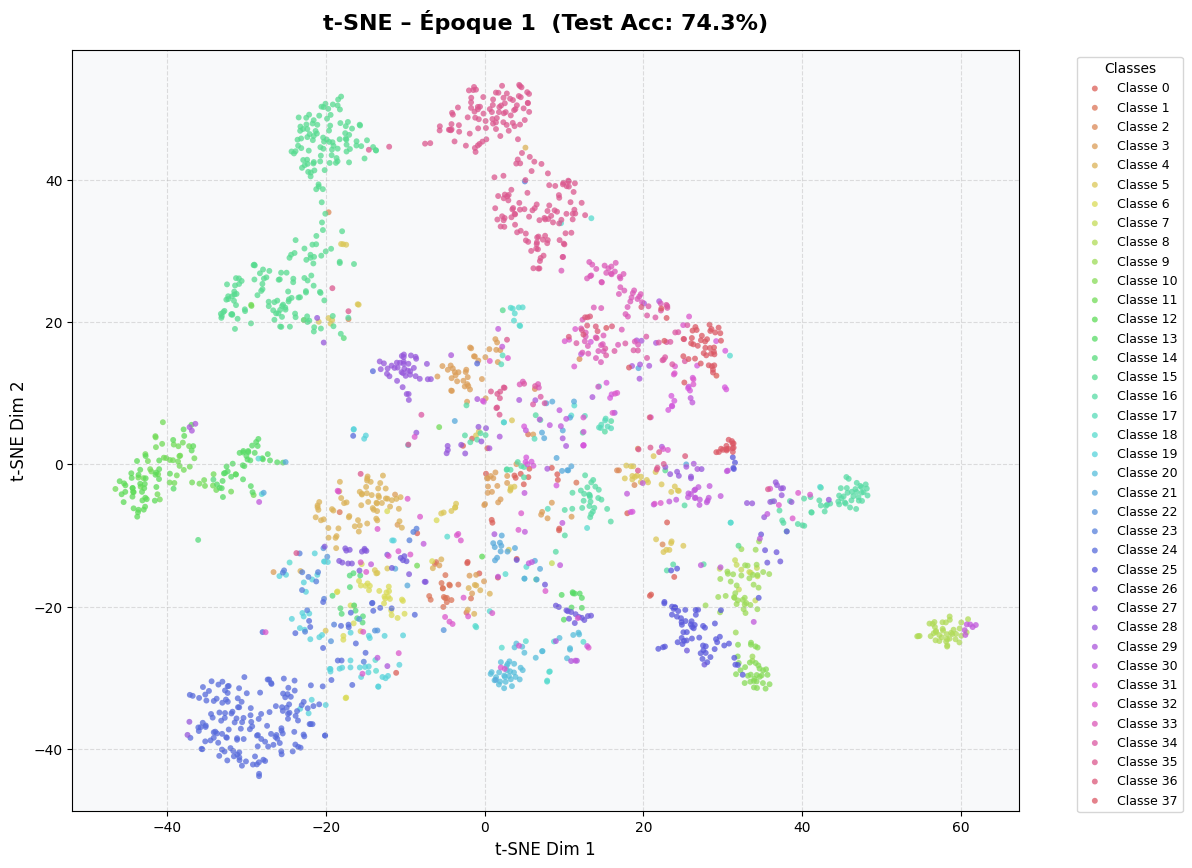

Epoch 2/5: 100%|██████████| 1358/1358 [01:16<00:00, 17.86it/s]


Epoch   2 │ Train 81.18%  │  Test  78.78%


Epoch 3/5: 100%|██████████| 1358/1358 [01:15<00:00, 18.05it/s]


Epoch   3 │ Train 86.81%  │  Test  84.16%


Epoch 4/5: 100%|██████████| 1358/1358 [01:15<00:00, 18.01it/s]


Epoch   4 │ Train 89.83%  │  Test  85.43%


Epoch 5/5: 100%|██████████| 1358/1358 [01:14<00:00, 18.14it/s]


Epoch   5 │ Train 92.07%  │  Test  86.90%

[t-SNE] Génération à l'époque 5 …


Extraction des features:  19%|█▊        | 63/340 [00:03<00:15, 18.20it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Réduction de (2000, 128) → 2D  (perplexity=30, n_iter=1000) …
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 8.160415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.413925
[t-SNE] KL divergence after 1000 iterations: 0.875835
[t-SNE] Figure sauvegardée → tsne_epoch_005.png


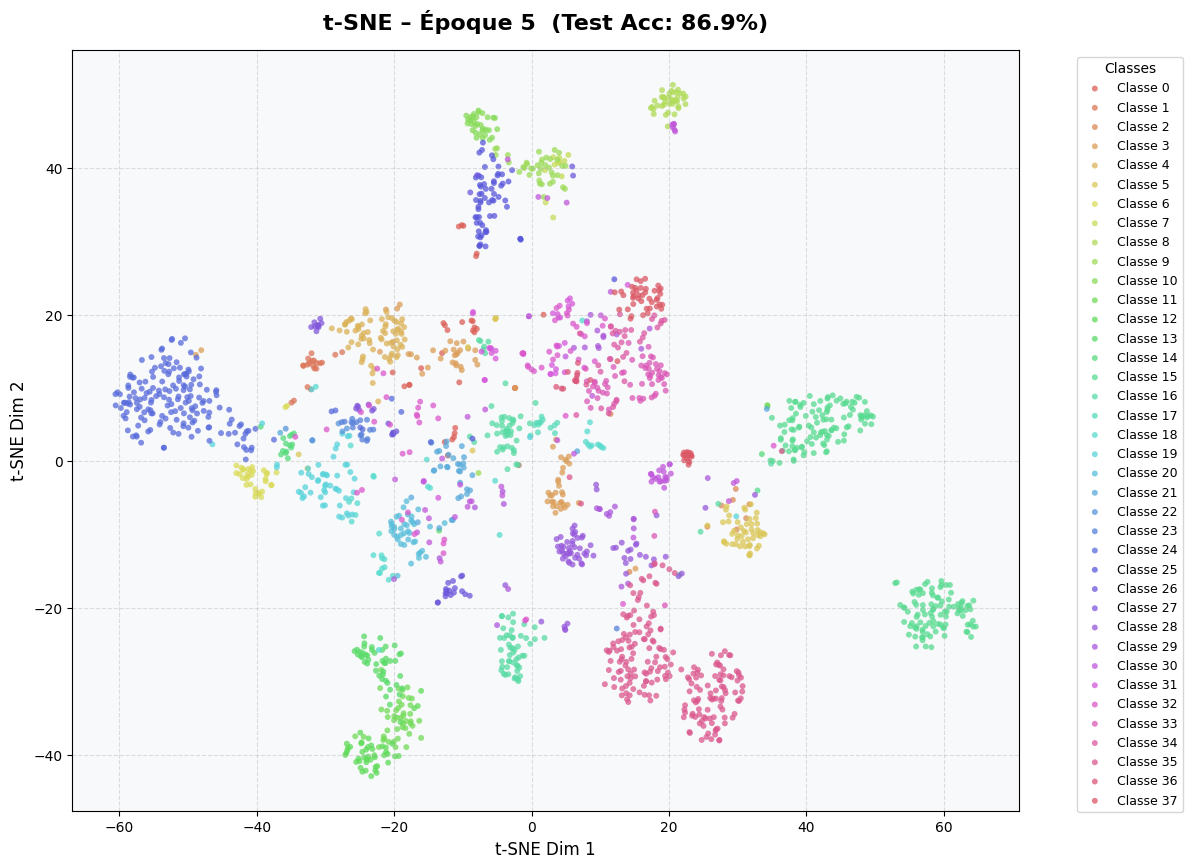

In [9]:
#def train_model(model, train_loader, test_loader, epochs=10):
#    # Dictionnaire pour sauvegarder l'historique des métriques
#    history = {
#        'train_loss': [], 'train_acc': [],
#        'test_loss': [], 'test_acc': []
#    }

#    for epoch in range(epochs):
#        model.train()
#        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#            images, labels = images.to(device), labels.to(device)

#            outputs = model(images)
#            loss = criterion(outputs, labels)

#            optimizer.zero_grad()
#            loss.backward()
#            optimizer.step()

        # Phase d'évaluation sur l'ensemble d'entraînement
#        model.eval()
#        train_loss, train_correct, train_total = 0, 0, 0
#        with torch.no_grad():
#            for images, labels in train_loader:
#                images, labels = images.to(device), labels.to(device)
#                outputs = model(images)
#                loss = criterion(outputs, labels)
#                train_loss += loss.item()
#                _, predicted = outputs.max(1)
#                train_total += labels.size(0)
#                train_correct += predicted.eq(labels).sum().item()

        # Savegarde des métriques d'entraînement
#        history['train_loss'].append(train_loss / len(train_loader))
#        history['train_acc'].append(100. * train_correct / train_total)

        # Phase d'évaluation sur l'ensemble de test
#        model.eval()
#        test_loss, test_correct, test_total = 0, 0, 0
#        with torch.no_grad():
#            for images, labels in test_loader:
#                images, labels = images.to(device), labels.to(device)
#                outputs = model(images)
#                loss = criterion(outputs, labels)
#                test_loss += loss.item()
#                _, predicted = outputs.max(1)
#                test_total += labels.size(0)
#                test_correct += predicted.eq(labels).sum().item()

        # Sauvegarde des métriques de test
#        history['test_loss'].append(test_loss / len(test_loader))
#        history['test_acc'].append(100. * test_correct / test_total)

#        print(f"Epoch {epoch+1}: Train Acc {history['train_acc'][-1]:.2f}%, Test Acc {history['test_acc'][-1]:.2f}%")

#    return history
def train_model(model, train_loader, test_loader,
                          epochs=1,
                          tsne_epochs=[1, 5],
                          class_names=None,
                          max_tsne_samples=2000):
    """
    Même logique que train_model, avec visualisation t-SNE
    automatique à des époques spécifiées.

    Args:
        tsne_epochs   : liste d'époques où afficher le t-SNE,
                        ex. [1, 5, 10].  None = uniquement à la fin.
        class_names   : noms des classes pour la légende
        max_tsne_samples : nb max d'échantillons pour le t-SNE
    """
    if tsne_epochs is None:
        tsne_epochs = [epochs]          # par défaut : seulement à la fin

    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss':  [], 'test_acc':  []
    }

    for epoch in range(1, epochs + 1):

        # ── Entraînement ──────────────────────────────────────
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss    = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ── Évaluation Train ──────────────────────────────────
        model.eval()
        train_loss, train_correct, train_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss    = criterion(outputs, labels)
                train_loss   += loss.item()
                _, predicted  = outputs.max(1)
                train_total  += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * train_correct / train_total)

        # ── Évaluation Test ───────────────────────────────────
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss    = criterion(outputs, labels)
                test_loss    += loss.item()
                _, predicted  = outputs.max(1)
                test_total   += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        history['test_loss'].append(test_loss / len(test_loader))
        history['test_acc'].append(100. * test_correct / test_total)

        print(f"Epoch {epoch:>3d} │ "
              f"Train {history['train_acc'][-1]:.2f}%  │  "
              f"Test  {history['test_acc'][-1]:.2f}%")

        # ── t-SNE à l'époque demandée ─────────────────────────
        if epoch in tsne_epochs:
            print(f"\n[t-SNE] Génération à l'époque {epoch} …")
            feats, lbls = extract_features(model, test_loader,
                                           device, max_tsne_samples)
            plot_tsne(
                feats, lbls,
                class_names=class_names,
                title=f"t-SNE – Époque {epoch}  "
                      f"(Test Acc: {history['test_acc'][-1]:.1f}%)",
                save_path=f"tsne_epoch_{epoch:03d}.png"
            )

    return history
# Appareil de calcul (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Préparer le modèle
model = PlantCNN(num_classes=len(dataset.classes)).to(device)

# Optimiseur et fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001) #on peut faire varier le learning rate
criterion = nn.CrossEntropyLoss()

# Lancer l'entraînement et sauvegarder l'historique
history = train_model(model, train_loader, test_loader, epochs=5)

## 6. Affichage de l'historique du loss et de l'accuracy vs le nombre d'epochs réalisées

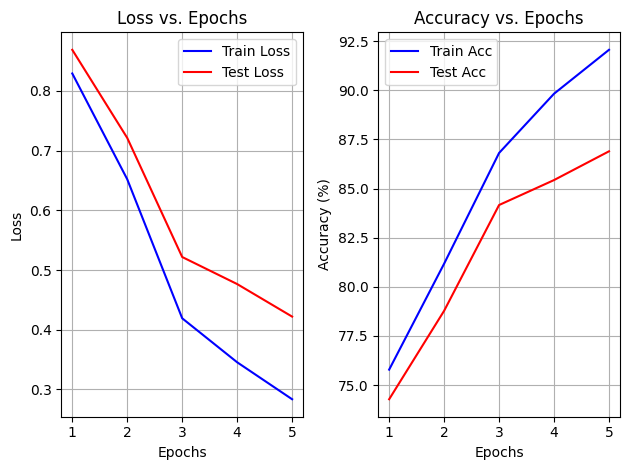

In [10]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('my_learning_curves.png') # Saves the plot in Colab
    # plt.show() # Uncomment this in Colab to see it inline

plot_history(history)